# hw3: Обучение без учителя

*Спасибо ещё одному великому курсу mlcourse.ai и авторам: Ольга Дайховская (@aiho в Slack ODS), Юрий Кашницкий (@yorko в Slack ODS).*

### О задании

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в
задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице.

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации.

**Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы, выделив ответ полужирным** (``` **выделить двойными звёздочками** ```).

### Оценивание и штрафы
Вам необходимо ответить на 10 вопросов и выполнить 2 задания. Каждое из заданий и вопросов имеет определенную «стоимость» (указана в скобках). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw3-unsupervised.ipynb``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце "hw3" в строке со своей фамилией о том, что вы выполнили работу и оставить ссылку на ноутбук.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt

plt.style.use(['seaborn-v0_8-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [2]:
X_train = np.loadtxt("X_train.txt")
y_train = np.loadtxt("y_train.txt").astype(int)

X_test = np.loadtxt("X_test.txt")
y_test = np.loadtxt("y_test.txt").astype(int)

In [3]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*.

In [4]:
# Ваш код здесь
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

Определим число уникальных значений меток целевого класса.

In [5]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [6]:
n_classes = np.unique(y).size

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

*уж простите, если звучание этих существительных кажется корявым :)*

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [7]:
# Ваш код здесь
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [8]:
# Ваш код здесь
pca = PCA(0.9, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

**Вопрос 1:** (1 балл)

Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

**Варианты:**
- 56
- **65**
- 66
- 193

In [9]:
print(len(pca.components_)) # Ваш код здесь

65


**Вопрос 2:** (0.5 баллов)

Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов.

**Варианты:**
- 45
- **51**
- 56
- 61

In [10]:
print(round(pca.explained_variance_ratio_[0] * 100))# Ваш код здесь

51


Визуализируйте данные в проекции на первые две главные компоненты.

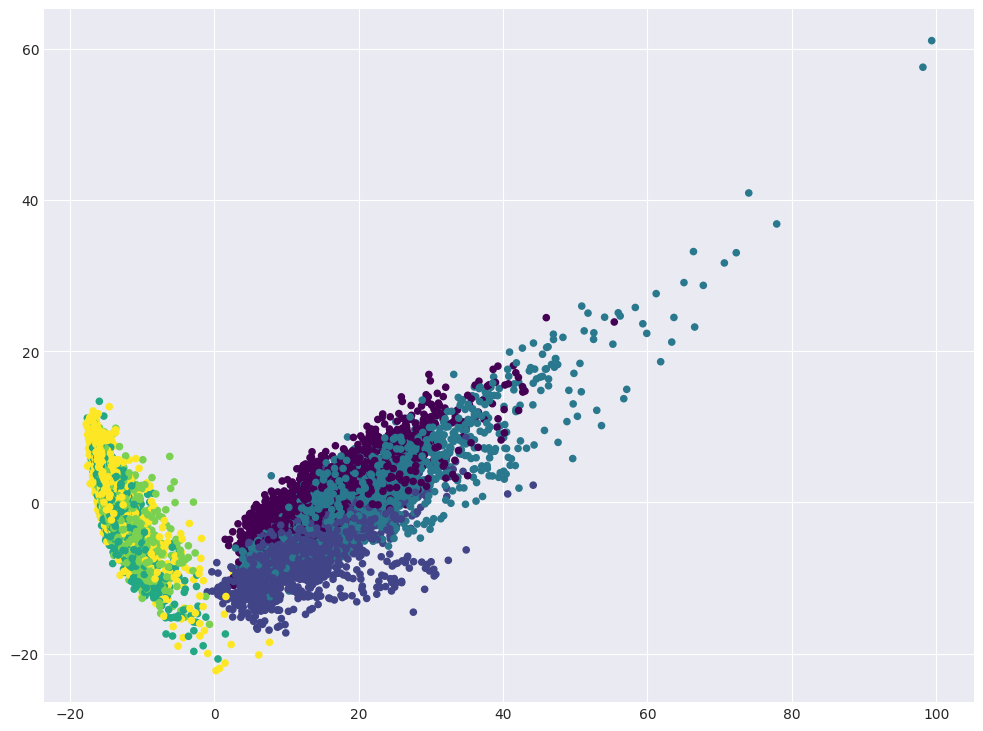

In [11]:
# Ваш код здесь
plt.scatter(X_pca[:, 0], X_pca[:, 1] , c=y, s=20, cmap='viridis');

**Вопрос 3:** (0.5 баллов)

Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 1 кластер: все 6 активностей
- **2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)**
- 3 кластера: (ходьба), (подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 6 кластеров

------------------------------

**Задание 1.** (1 балл)

Сделайте кластеризацию данных методом `KMeans` (собственная имплементация и готовая реализация), обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [12]:
# Ваш код здесь
kmeans = KMeans(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE)
X_class = kmeans.fit(X_pca)

class MyKMeans:
    def __init__(self, n_clusters, n_init=100, random_state=42,
                 max_iter=300, tol=1e-4):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.random_state = random_state
        self.max_iter = max_iter
        self.tol = tol

        # резы
        self.cluster_centers_ = None
        self.labels_ = None
        self.inertia_ = None
        self.n_iter_ = None

    def _initialize_centroids(self, X):
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape

        centroids = np.zeros((self.n_clusters, n_features))
        centroids[0] = X[np.random.randint(n_samples)]

        for i in range(1, self.n_clusters):
            dist = np.array([np.min([np.linalg.norm(x - c) ** 2
                                          for c in centroids[:i]])
                                 for x in X])

            probabilities = dist / dist.sum()

            cumulative_probs = np.cumsum(probabilities)
            r = np.random.rand()
            for j, p in enumerate(cumulative_probs):
                if r < p:
                    centroids[i] = X[j]
                    break

        return centroids

    def _compute_inertia(self, X, labels, centers):
        inertia = 0.0
        for i in range(self.n_clusters):
            cluster_points = X[labels == i]
            if len(cluster_points) > 0:
                inertia += np.sum((cluster_points - centers[i]) ** 2)
        return inertia

    def _single_run(self, X, initial_centers):
        centers = initial_centers.copy()
        prev_inertia = float('inf')

        for iteration in range(self.max_iter):
            dist = np.zeros((X.shape[0], self.n_clusters))
            for i in range(self.n_clusters):
                dist[:, i] = np.sum((X - centers[i]) ** 2, axis=1)
            labels = np.argmin(dist, axis=1)

            new_centers = np.zeros_like(centers)
            for i in range(self.n_clusters):
                cluster_points = X[labels == i]
                if len(cluster_points) > 0:
                    new_centers[i] = np.mean(cluster_points, axis=0)
                else:
                    new_centers[i] = X[np.random.randint(X.shape[0])]

            inertia = self._compute_inertia(X, labels, new_centers)

            if abs(prev_inertia - inertia) < self.tol:
                break

            centers = new_centers
            prev_inertia = inertia

        return centers, labels, inertia, iteration + 1

    def fit(self, X, y=None):
        X = np.asarray(X)
        n_samples, n_features = X.shape

        if n_samples < self.n_clusters:
            raise ValueError(f"n_samples={n_samples} должно быть >= n_clusters={self.n_clusters}")

        best_inertia = float('inf')
        best_centers = None
        best_labels = None
        best_n_iter = 0

        for init in range(self.n_init):
            initial_centers = self._initialize_centroids(X)

            centers, labels, inertia, n_iter = self._single_run(X, initial_centers)

            if inertia < best_inertia:
                best_inertia = inertia
                best_centers = centers
                best_labels = labels
                best_n_iter = n_iter

        self.cluster_centers_ = best_centers
        self.labels_ = best_labels
        self.inertia_ = best_inertia
        self.n_iter_ = best_n_iter

        return self

    def predict(self, X):
        if self.cluster_centers_ is None:
            raise ValueError("Модель не обучена. Сначала fit")

        X = np.asarray(X)
        n_samples = X.shape[0]
        n_clusters = self.cluster_centers_.shape[0]

        dist = np.zeros((n_samples, n_clusters))
        for i in range(n_clusters):
            dist[:, i] = np.sum((X - self.cluster_centers_[i]) ** 2, axis=1)

        labels = np.argmin(dist, axis=1)

        return labels

    def fit_predict(self, X, y=None):
        self.fit(X, y)
        return self.labels_

    def score(self, X):
        labels = self.predict(X)
        return self._compute_inertia(X, labels, self.cluster_centers_)

my_kmeans = MyKMeans(
    n_clusters=n_classes,
    n_init=100,
    random_state=RANDOM_STATE
)
my_kmeans.fit(X_pca)

print(my_kmeans.inertia_)
print(kmeans.inertia_)

2003454.7982992884
2003454.899915828


Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

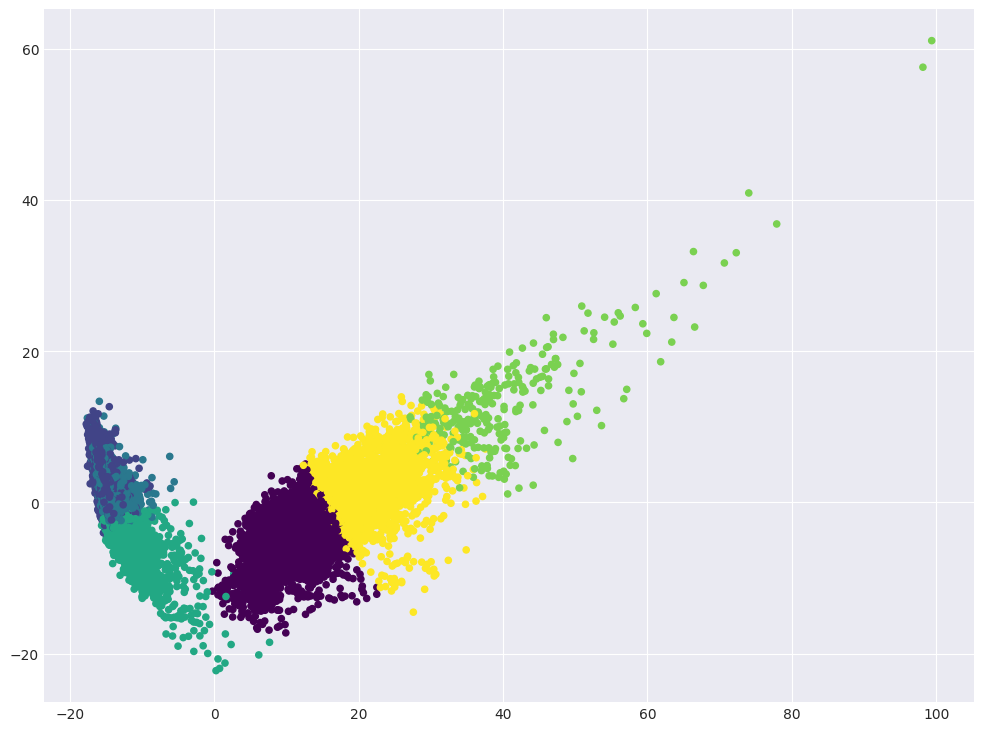

In [13]:
# Ваш код здесь
cluster_labels = my_kmeans.labels_
plt.scatter(X_pca[:,0], X_pca[:, 1] , c=cluster_labels, s=20,  cmap='viridis');

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [14]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице',
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,903,0,0,0,78,741,1722
подъем вверх по лестнице,1241,0,0,2,5,296,1544
спуск по лестнице,320,0,0,0,196,890,1406
сидение,1,91,1235,450,0,0,1777
стояние,0,0,1344,562,0,0,1906
лежание,5,1558,52,329,0,0,1944
все,2470,1649,2631,1343,279,1927,10299


Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации.

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,

то такая доля будет 900 / 1406 $\approx$ 0.64.


**Вопрос 4:** (1 балл)

Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
- ходьба
- стояние
- спуск по лестнице
- **перечисленные варианты не подходят**

Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

/tmp/ipython-input-1849920821.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(1, n_classes + 1)):


  0%|          | 0/6 [00:00<?, ?it/s]

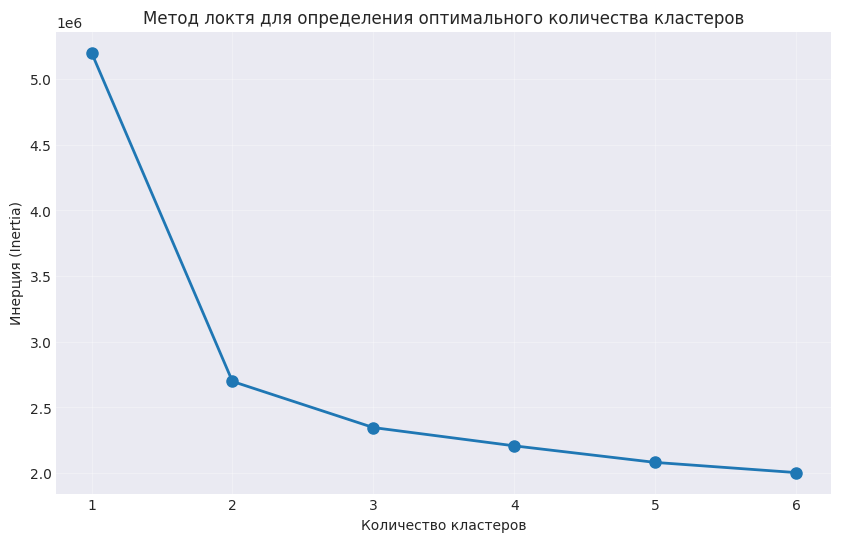

In [15]:
# Ваш код здесь


inertia = []
for k in tqdm_notebook(range(1, n_classes + 1)):
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, n_classes + 1), inertia, marker='o', linewidth=2, markersize=8)
plt.xlabel('Количество кластеров')
plt.ylabel('Инерция (Inertia)')
plt.title('Метод локтя для определения оптимального количества кластеров')
plt.grid(True, alpha=0.3)
plt.xticks(range(1, n_classes + 1))
plt.show()

**Вопрос 5:** (1 балл)

Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 1
- **2**
- 3
- 4

------------------------

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [16]:
ag = AgglomerativeClustering(n_clusters=n_classes,
                             linkage='ward').fit(X_pca)

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [17]:
# Ваш код здесь
print(f"AG: {metrics.adjusted_rand_score(y, ag.labels_)}")
kmeans = KMeans(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE).fit(X_pca)
print(f"KMeans: {metrics.adjusted_rand_score(y, cluster_labels)}")


AG: 0.49362763373004886
KMeans: 0.4198070012602345


**Вопрос 6:** (1 балл)

Отметьте все верные утверждения.<br>

**Варианты:**
- **Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering**
- **Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры**
- **В случае случайного разбиения на кластеры ARI будет близок к нулю**

-------------------------------

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf).

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`.

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), прмиените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [18]:
# Ваш код здесь
#
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [19]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [20]:
# Ваш код здесь
grid_search = GridSearchCV(svc, svc_params, cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)
best_svc = grid_search.best_estimator_

Fitting 3 folds for each of 5 candidates, totalling 15 fits


In [21]:
# Ваш код здесь
print("Лучший гиперпараметр:", grid_search.best_params_)
print("Лучший скор:", grid_search.best_score_)

Лучший гиперпараметр: {'C': 0.1}
Лучший скор: 0.9379785010699506


**Вопрос 7** (0.5 баллов)

Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

**Ответ:**
- 0.001
- 0.01
- **0.1**
- 1
- 10

In [22]:
y_predicted = best_svc.predict(X_test_scaled)

In [23]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице',
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,479,11,4,2,0,0,496
подъем вверх по лестнице,4,465,1,1,0,0,471
спуск по лестнице,1,2,416,1,0,0,420
сидение,0,4,0,433,52,2,491
стояние,0,0,0,16,516,0,532
лежание,0,0,0,0,7,530,537
все,484,482,421,453,575,532,2947


**Вопрос 8:** (0.5 балл)

Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

**Ответ:**
- по точности – подъем вверх по лестнице, по полноте – лежание
- по точности – лежание, по полноте – сидение
- по точности – ходьба, по полноте – ходьба
- **по точности – сидение, по полноте – стояние**

Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

- Используйте выборки `X_train_scaled` и `X_test_scaled`
- Обучите тот же PCA, что раньше, на отмасшабированной обучающей выборке, примените преобразование к тестовой
- Настройте гиперпараметр `C` на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.



In [24]:
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(
    estimator=svc,
    param_grid=svc_params,
    cv=3,
    n_jobs=-1,
)
grid.fit(X_train_pca, y_train)
best_svc_pca = grid.best_estimator_
print("Лучший гиперпараметр:", grid.best_params_)
print("Лучший скор:", grid.best_score_)

print(f"{round(abs(grid_search.best_score_ - grid.best_score_)* 100)}%")

Лучший гиперпараметр: {'C': 0.1}
Лучший скор: 0.8983982658750974
4%


**Вопрос 9:** (1 балл)

Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**Варианты:**
- Качество одинаковое
- 2%
- **4%**
- 10%
- 20%


**Вопрос 10:** (1 балл)

Выберите все верные утверждения:

**Варианты:**
- Метод главных компонент в данном случае позволил уменьшить время обучения модели, при этом качество (доля верных ответов на кросс-валидации) очень пострадало, более чем на 10%
- **PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность**
- **PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком**

**Задание 2.** (1 балл)

Попробуйте использовать DBSCAN в качестве алгоритма кластеризации и метод понижения размерности tSNE.

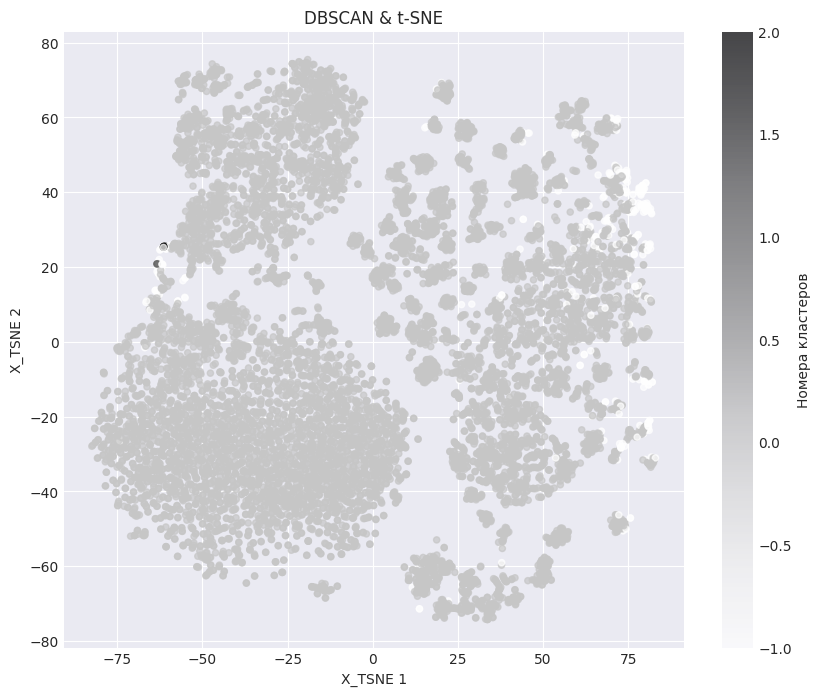

In [25]:
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

tsne = TSNE(n_components=2, random_state=RANDOM_STATE)
X_tsne = tsne.fit_transform(X_pca)
db = DBSCAN(eps=16.5, min_samples=3)
X_db = db.fit_predict(X_pca)
plt.figure(figsize=(10, 8))
plt.scatter(
    X_tsne[:, 0],
    X_tsne[:, 1],
    c=db.labels_,
    s=20,
    alpha=0.7
)
plt.colorbar(label='Номера кластеров')
plt.title(f'DBSCAN & t-SNE')
plt.xlabel('X_TSNE 1')
plt.ylabel('X_TSNE 2')
plt.show()